In [39]:
import pandas as pd
import numpy as np
import sqlite3


In [40]:
query = """
SELECT 
    s.sensor_index, 
    s.name, 
    s.latitude, 
    s.longitude, 
    d.time_stamp,
    d.humidity_a, 
    d.temperature_a, 
    d.pressure_a, 
    d."pm2.5_atm_a", 
    d."pm2.5_atm_b", 
    d."pm2.5_cf_1_a", 
    d."pm2.5_cf_1_b"
FROM 
    sensor_table AS s
JOIN 
    data_table AS d
ON 
    s.sensor_index = d.sensor_index
    
"""

with sqlite3.connect('../datasets/dallas.sqlite') as db:
    data = pd.read_sql(query, db)

In [41]:
data['time_stamp'] = pd.to_datetime(data['time_stamp'])

In [42]:
data.set_index('time_stamp', inplace=True)
data =  data.sort_index(ascending=True)


In [43]:
data.index = data.index.date # change index to date format

In [44]:
# Merging weather data from noaa to the data from a single sensor
weather_noaa_data = pd.read_csv('../datasets/Dallas_stations_data.csv')

weather_noaa_data_w =  weather_noaa_data[weather_noaa_data['STATION']=='USW00003971'][['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND', 'DAPR', 'MDPR', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG','TMAX','TMIN', 'WDF2','WDF5', 'WESD', 'WESF','WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06','WT08']]

weather_noaa_data_w_n = weather_noaa_data_w[:-2] # the noaa data is for two days longer

weather_noaa_data_w_n = weather_noaa_data_w_n.fillna(0) # lot's of NAN values, which are essentially zeros

In [45]:
weather_noaa_data_w_n['DATE'] = pd.to_datetime(weather_noaa_data_w_n['DATE'])
weather_noaa_data_w_n.set_index('DATE', inplace=True) # setting index makes it easier to merge later

In [46]:
merged_df = pd.merge(data, weather_noaa_data_w_n, how = 'left', left_index=True, right_index=True)

In [47]:
start_date = '2022-04-01'
end_date = '2024-03-29'

# Filter the DataFrame for rows within the specified range
filtered_merged_df = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)]


In [48]:
# Reset the index and rename the index column
filtered_merged_df = filtered_merged_df.reset_index().rename(columns={'index': 'time_stamp'})

In [49]:
filtered_merged_df

,time_stamp,sensor_index,name,latitude,longitude,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,...,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08
0,2022-04-01,87721,Garland,32.963880,-96.634650,31.406,66.424,996.667,4.720,3.450,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-04-01,90785,HeathWeather,32.819980,-96.466545,39.826,61.796,998.508,3.981,3.353,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-04-01,113708,UNT-GEO-56,33.259953,-97.257290,42.803,59.520,990.216,1.014,1.565,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-04-01,127067,UNT-GEO-39,33.149710,-97.126010,38.254,62.729,995.100,0.373,0.606,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-04-01,59903,UNT-GEO-32,33.112953,-97.121280,33.125,66.057,994.619,3.595,4.456,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39792,2024-03-29,113969,UNT-GEO-58,33.114075,-97.365974,75.111,68.013,988.733,0.845,3298.304,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39793,2024-03-29,99585,Aldersyde,32.921955,-97.305560,72.486,73.772,989.039,2.805,4.284,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39794,2024-03-29,114119,UNT-GEO-44,33.238647,-97.109695,46.908,72.577,992.503,0.796,1.034,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39795,2024-03-29,144032,LOCHWOOD,32.861404,-96.687240,49.159,72.571,996.867,5.734,5.654,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
filtered_merged_df = filtered_merged_df[filtered_merged_df['pm2.5_atm_a']<1000]

In [76]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

# Function to convert latitude and longitude to Cartesian coordinates
def lat_lon_to_cartesian(lat, lon, radius=6371.0):
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return x, y, z

# Function to create a spatial map for a given timestamp
def create_spatial_map(data, timestamp, grid_x, grid_y):
    subset = data[data['time_stamp'] == timestamp]
    lat = np.radians(subset['latitude'].values)
    lon = np.radians(subset['longitude'].values)
    values = subset['pm2.5_atm_a'].values
    
    # Convert latitude and longitude to Cartesian coordinates
    cartesian_points = np.array([lat_lon_to_cartesian(lat_i, lon_i) for lat_i, lon_i in zip(lat, lon)])
    
    # Ensure cartesian_points has the correct shape
    cartesian_points = cartesian_points.reshape(-1, 3)
    
    # Interpolate using griddata
    grid_z = griddata(cartesian_points[:, :2], values, (grid_x, grid_y), method='nearest')
    
    return grid_z

# Example dataset ranges
min_latitude = filtered_merged_df['latitude'].min()
max_latitude = filtered_merged_df['latitude'].max()
min_longitude = filtered_merged_df['longitude'].min()
max_longitude = filtered_merged_df['longitude'].max()

# Convert min and max latitude and longitude to radians
min_lat_rad = np.radians(min_latitude)
max_lat_rad = np.radians(max_latitude)
min_lon_rad = np.radians(min_longitude)
max_lon_rad = np.radians(max_longitude)

# Convert the bounding coordinates to Cartesian coordinates
min_x, min_y, _ = lat_lon_to_cartesian(min_lat_rad, min_lon_rad)
max_x, max_y, _ = lat_lon_to_cartesian(max_lat_rad, max_lon_rad)

# Define grid resolution (in Cartesian coordinates)
x_resolution = (max_x - min_x) / 100
y_resolution = (max_y - min_y) / 100  

# Create grid points in Cartesian coordinates
grid_x, grid_y = np.meshgrid(np.arange(min_x, max_x, x_resolution), np.arange(min_y, max_y, y_resolution))

# Generate spatial maps for all timestamps
timestamps = filtered_merged_df['time_stamp'].unique()
spatial_maps = [create_spatial_map(filtered_merged_df, ts, grid_x, grid_y) for ts in timestamps]
spatial_maps = np.array(spatial_maps)


In [78]:
spatial_maps[0].shape

(100, 101)

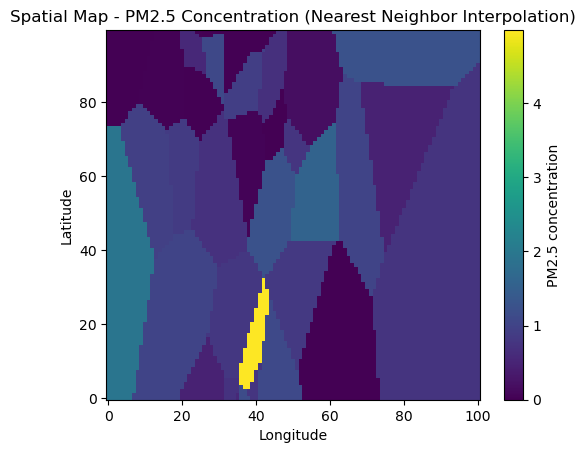

In [79]:
import matplotlib.pyplot as plt
plt.imshow(spatial_maps[6], origin='lower', cmap='viridis')
plt.colorbar(label='PM2.5 concentration')
plt.title('Spatial Map - PM2.5 Concentration (Nearest Neighbor Interpolation)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
